# Module 1 Homework

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_parquet(r"Data\fhv_tripdata_2021-01.parquet")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


## Exploratory Analysis & Preprocessing
#### Trip duration

In [4]:
data["duration"] = (
    pd.to_datetime(data["dropOff_datetime"]) - 
    pd.to_datetime(data["pickup_datetime"])
)
data["duration"] = data.duration.apply(lambda x: x.total_seconds() / 60)

In [5]:
data.sample(5)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
845521,B01083,2021-01-23 20:09:03,2021-01-23 20:32:29,NaN,32.0,None,B01083,23.433333
221185,B01231,2021-01-07 12:50:19,2021-01-07 13:05:52,NaN,112.0,None,B02872,15.550000
782925,B01236,2021-01-22 08:51:00,2021-01-22 09:26:00,NaN,NaN,None,B01236,35.000000
129032,B01958,2021-01-05 09:07:00,2021-01-05 09:49:00,NaN,NaN,None,B01958,42.000000
324960,B00350,2021-01-10 10:05:08,2021-01-10 10:18:07,NaN,173.0,None,B00350,12.983333


In [6]:
data["duration"].mean()

19.1672240937939

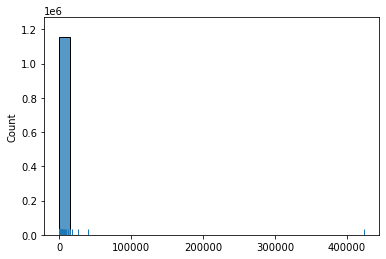

Wall time: 14.3 s


In [7]:
%%time
sns.histplot(x=data["duration"].values, bins=30)
sns.rugplot(x=data["duration"].values)
plt.show()

In [8]:
data.describe().round()

,PUlocationID,DOlocationID,duration
count,195845.0,991892.0,1154112.0
mean,140.0,136.0,19.0
std,75.0,80.0,399.0
min,1.0,1.0,0.0
25%,75.0,67.0,8.0
50%,143.0,132.0,13.0
75%,206.0,213.0,22.0
max,265.0,265.0,423371.0


In [9]:
mask = (data.duration <= 60) & (data.duration >= 1.0)
len(data) - len(data.loc[mask])

44286

In [10]:
data = data.loc[mask]

#### Missing values

In [11]:
(data.isna().sum() / len(data)) * 100

dispatching_base_num        0.000000
pickup_datetime             0.000000
dropOff_datetime            0.000000
PUlocationID               83.527328
DOlocationID               13.327044
SR_Flag                   100.000000
Affiliated_base_number      0.069651
duration                    0.000000
dtype: float64

In [12]:
data[["PUlocationID","DOlocationID"]] = data[["PUlocationID","DOlocationID"]].fillna(-1)

## Modeling

#### Encoding

In [13]:
features = ["PUlocationID","DOlocationID"]
target = "duration"

In [14]:
X_train = data[features].astype(str)
y_train = data[target].values

In [15]:
train_dicts = X_train.to_dict(orient="records")

In [16]:
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_dicts)

In [17]:
len(vectorizer.feature_names_)

525

#### Training

In [18]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [19]:
y_train_pred = regressor.predict(X_train)
print("Error:", mean_squared_error(y_train, y_train_pred, squared=False))

Error: 10.528519107202131


#### Evaluation

In [20]:
data_val = pd.read_parquet(r"Data\fhv_tripdata_2021-02.parquet")

In [21]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037692 entries, 0 to 1037691
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1037692 non-null  object        
 1   pickup_datetime         1037692 non-null  datetime64[ns]
 2   dropOff_datetime        1037692 non-null  datetime64[ns]
 3   PUlocationID            153001 non-null   float64       
 4   DOlocationID            885340 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1037692 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 55.4+ MB


In [22]:
# Preprocessing
data_val["duration"] = (
    pd.to_datetime(data_val["dropOff_datetime"]) - 
    pd.to_datetime(data_val["pickup_datetime"])
)
data_val["duration"] = data_val["duration"] .apply(lambda x: x.total_seconds() / 60)
duration_mask = (data_val["duration"] <= 60) & (data_val["duration"] >= 1.0)
data_val = data_val.loc[duration_mask]
data_val[["PUlocationID","DOlocationID"]] = data_val[["PUlocationID","DOlocationID"]].fillna(-1)

In [23]:
X_val = data_val[features].astype(str)
y_val = data_val[target].values

In [24]:
val_dicts = X_val.to_dict(orient="records")
X_val = vectorizer.transform(val_dicts)

In [25]:
y_val_pred = regressor.predict(X_val)
print("Error:", mean_squared_error(y_val, y_val_pred, squared=False))

Error: 11.01428311525346
